## Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer 
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier

# General settings
plt.rcParams['figure.figsize'] = (4, 3)
sns.set(context='paper')
warnings.filterwarnings('ignore')

## Data Ingestion

In [2]:
# Load data
df = pd.read_csv('recipe_site_traffic_2212.csv', index_col='recipe')

## Data Validation and Wrangling

In [3]:
# Round 'Nutritional Facts' columns so that they 
cols = ['calories', 'carbohydrate', 'sugar', 'protein']
df[cols] = df[cols].round()

# Wrangle 'servings' column. Extract only integers.
df['servings'] = df['servings'].str[:1].astype(int)

# Recode 'high_traffic' column where True = 'high_traffic'
df['high_traffic'] = np.where(df['high_traffic'].isnull(), False, True)

# Wrangle 'category' column
df['category'] = df['category'].str.replace(' Breast', '').astype('category')

# Sort columns
num_features = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
cat_features = ['category']
target = ['high_traffic']
df = df[num_features + cat_features + target]

## Exploratory Analysis

In [4]:
# Display first rows.
df.head()

,calories,carbohydrate,sugar,protein,servings,category,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,6,Pork,True
2,35.0,39.0,1.0,1.0,4,Potato,True
3,914.0,43.0,3.0,3.0,1,Breakfast,False
4,97.0,31.0,39.0,0.0,4,Beverages,True
5,27.0,2.0,1.0,1.0,4,Beverages,False


In [5]:
# Display data types and nulls count
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   servings      947 non-null    int32   
 5   category      947 non-null    category
 6   high_traffic  947 non-null    bool    
dtypes: bool(1), category(1), float64(4), int32(1)
memory usage: 42.9 KB


There is a presence of null values in the columns related to nutritional value. They will be imputted later.

In [6]:
# Display basic stats of numeric columns
df.describe().round(2)

,calories,carbohydrate,sugar,protein,servings
count,895.00,895.00,895.00,895.00,947.00
mean,435.96,35.07,9.06,24.15,3.48
std,453.00,43.95,14.68,36.38,1.73
min,0.00,0.00,0.00,0.00,1.00
25%,110.50,8.00,2.00,3.00,2.00
50%,289.00,21.00,5.00,11.00,4.00
75%,598.00,45.00,10.00,30.00,4.00
max,3633.00,530.00,149.00,363.00,6.00


In [7]:
# Display basic stats of non-numeric columns
df.describe(include=['category', bool])

,category,high_traffic
count,947,947
unique,10,2
top,Chicken,True
freq,172,574


### Target Variable

#### High_traffic

There is class balance in the target variable. The majority class is True, which represents recipes which resulted in high traffic.

In [8]:
# Calculate class balance
target = 'high_traffic'

n = df[target].value_counts().rename('n')
p = df[target].value_counts(normalize=True).rename('p').round(2)

table = pd.concat([n, p], axis=1).rename_axis(target).reset_index()
table

,high_traffic,n,p
0,True,574,0.61
1,False,373,0.39


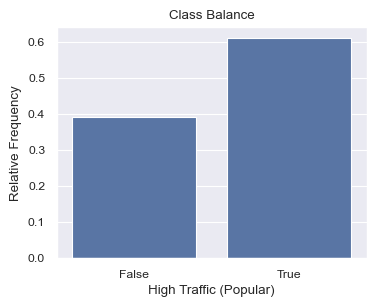

In [9]:
# Plot class balance
sns.barplot(data=table, x=target, y='p')
plt.ylabel('Relative Frequency')
plt.title('Class Balance')
plt.xlabel('High Traffic (Popular)');

## Feature Variables

### Calories

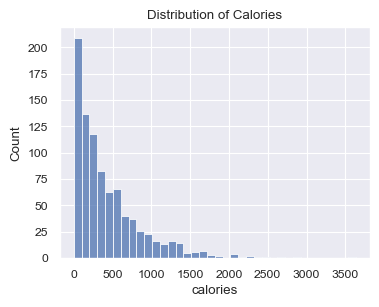

In [10]:
feature = 'calories'

# Plot distribution of Calories
sns.histplot(df[feature])
plt.title('Distribution of Calories');

This feature is positively skewed. There are some recipes with very high amounts of calories.

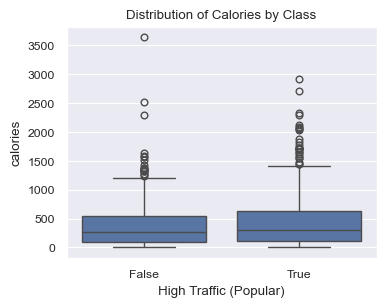

In [11]:
# Plot distribution of Calories by Class
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Calories by Class')
plt.xlabel('High Traffic (Popular)');

The number of calories does not seem to have significant impact on high_traffic. 

In [12]:
# Calculate average of Calories by Class
df.groupby(target)[feature].mean().round(2).reset_index()

,high_traffic,calories
0,False,394.91
1,True,463.58


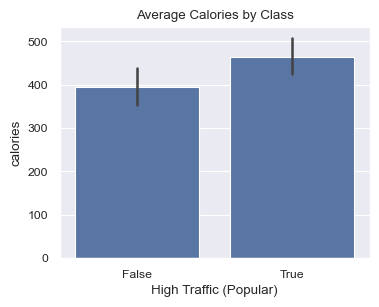

In [13]:
# Plot average of Calories by Class
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Calories by Class')
plt.xlabel('High Traffic (Popular)');

### Carbohydrate

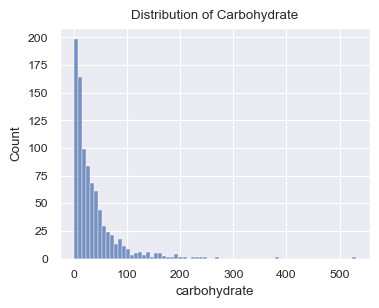

In [14]:
feature = 'carbohydrate'

# Plot distribution of Carbohydrate
sns.histplot(df[feature])
plt.title('Distribution of Carbohydrate');

This feature is positively skewed. There are some recipes with very high amounts of carbohydrates.

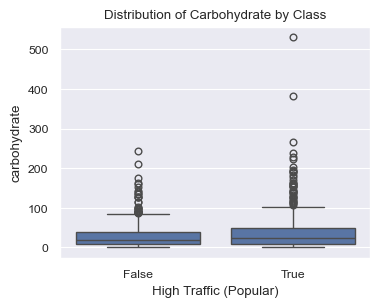

In [15]:
# Plot distribution of Carbohydrate by Class
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Carbohydrate by Class')
plt.xlabel('High Traffic (Popular)');

The number of carbohydrates does not seem to have significant impact on high_traffic. 

In [16]:
# Calculate average of Carbohydrates by Class
df.groupby(target)[feature].mean().round(2).reset_index()

,high_traffic,carbohydrate
0,False,30.73
1,True,37.99


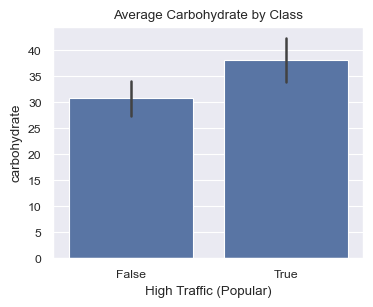

In [17]:
# Plot average of Carbohydrates by Class
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Carbohydrate by Class')
plt.xlabel('High Traffic (Popular)');

### Sugar

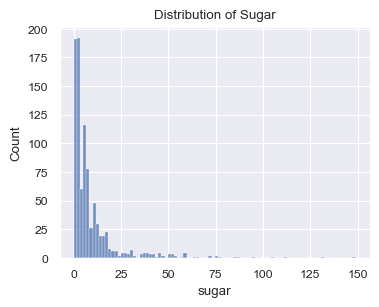

In [18]:
feature = 'sugar'

# Plot distribution of Sugar
sns.histplot(df[feature])
plt.title('Distribution of Sugar');

This feature is positively skewed. There are some recipes with very high amounts of sugar.

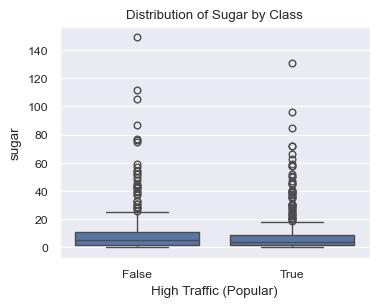

In [19]:
# Plot distribution of Sugar by Class
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Sugar by Class')
plt.xlabel('High Traffic (Popular)');

In [20]:
# Calculate average of Sugar by Class
df.groupby(target)[feature].mean().round(2).reset_index()

,high_traffic,sugar
0,False,10.41
1,True,8.15


The amount of sugar does not seem to have significant impact on high_traffic. 

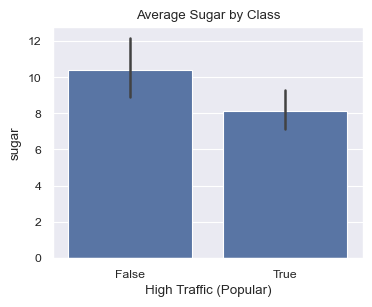

In [21]:
# Plot average of Sugar by Class
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Sugar by Class')
plt.xlabel('High Traffic (Popular)');

### Protein

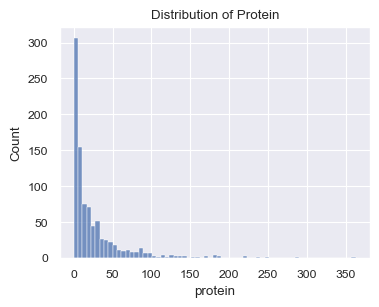

In [22]:
feature = 'protein'

# Plot distribution of Protein
sns.histplot(df[feature])
plt.title('Distribution of Protein');

This feature is positively skewed. There are some recipes with very high amounts of protein.

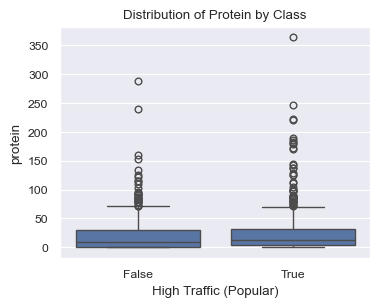

In [23]:
# Plot distribution of Protein by Class
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Protein by Class')
plt.xlabel('High Traffic (Popular)');

In [24]:
# Calculate average of Protein by Class
df.groupby(target)[feature].mean().round(2).reset_index()

,high_traffic,protein
0,False,22.17
1,True,25.47


The number of proteins does not seem to have significant impact on high_traffic. 

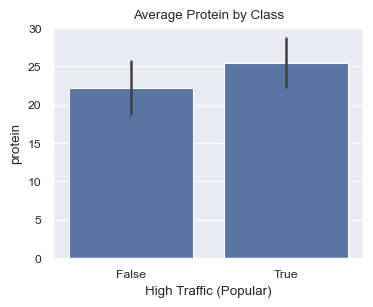

In [25]:
# Plot average of Protein by Class
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Protein by Class')
plt.xlabel('High Traffic (Popular)');

### Category

Historically, almost 50% of the recipes have been of the categories 'chicken', 'breakfast', 'beverages', 'lunch/snacks'.

In [44]:
feature = 'category'

# Calculate proportions of each category in the dataset.
df[feature].value_counts(normalize=True).round(2)

category
Chicken          0.18
Breakfast        0.11
Beverages        0.10
Lunch/Snacks     0.09
Potato           0.09
Pork             0.09
Dessert          0.09
Vegetable        0.09
Meat             0.08
One Dish Meal    0.07
Name: proportion, dtype: float64

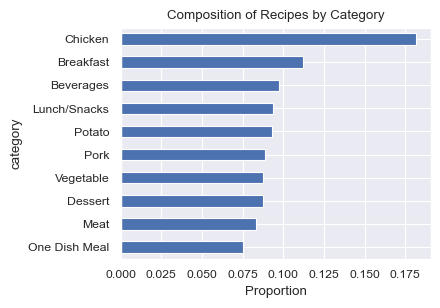

In [45]:
# Plot proportions of each category in the dataset.
df[feature].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh')
plt.title('Composition of Recipes by Category')
plt.xlabel('Proportion');

In [46]:
# Obtain the average of high_traffic by Category.
x = df.groupby(feature, observed=False)[target].mean().round(4).sort_values(ascending=False)
x

category
Vegetable        0.9880
Potato           0.9432
Pork             0.9167
Meat             0.7468
One Dish Meal    0.7324
Lunch/Snacks     0.6404
Dessert          0.6386
Chicken          0.4244
Breakfast        0.3113
Beverages        0.0543
Name: high_traffic, dtype: float64

Certain categories of recipes are associated with high traffic recipes. In order of importance, these include: Vegetable, Potato, Pork, Meat, and One Dish Meal.

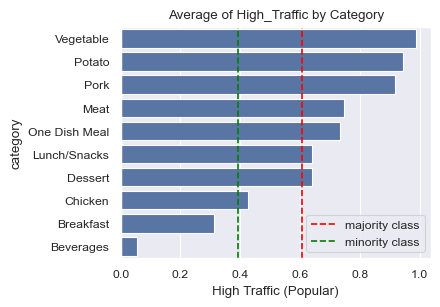

In [47]:
# Obtain majority and minority class proportions
majority_class_prop, minority_class_prop = df['high_traffic'].value_counts(normalize=True)

# Plot average of high_traffic by Category
sns.barplot(data=df, x='high_traffic', y=feature, orient='h', order=x.index, color='b', ci=None)
plt.axvline(majority_class_prop, linestyle='--', color='red', label='majority class')
plt.axvline(minority_class_prop, linestyle='--', color='green', label='minority class')
plt.title('Average of High_Traffic by Category')
plt.xlabel('High Traffic (Popular)');
plt.legend(loc='lower right');

### Servings

In [30]:
feature = 'servings'

# Calculate the proportion of servings in the dataset.
df[feature].value_counts(normalize=True).round(2)

servings
4    0.41
6    0.21
2    0.19
1    0.18
Name: proportion, dtype: float64

The number of servings does not seem to be associated with high traffic recipes.

In [31]:
# Calculate the average of high_traffic by servings.
df.groupby(feature, observed=False)[target].mean().round(2).sort_values(ascending=False)

servings
6    0.65
4    0.61
1    0.59
2    0.57
Name: high_traffic, dtype: float64

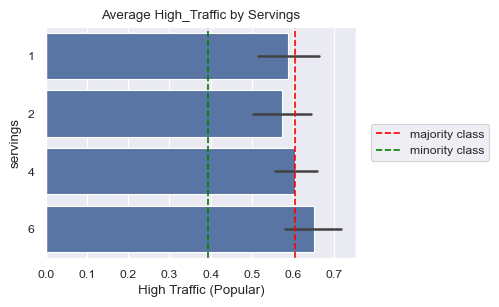

In [32]:
# Plot the average of high_traffic by servings.
sns.barplot(data=df, x=target, y=feature, orient='h', color='b')
plt.title('Average High_Traffic by Servings')
plt.axvline(majority_class_prop, linestyle='--', color='red', label='majority class')
plt.axvline(minority_class_prop, linestyle='--', color='green', label='minority class')
plt.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))
plt.xlabel('High Traffic (Popular)');

## Model Development

### Split

In [33]:
# Select features and target.
target = 'high_traffic'

X = df.drop(columns=target)
y = df[target]

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (947, 6)
y shape: (947,)


In [34]:
# Splitt data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (757, 6)
y_train shape: (757,)
X_test shape: (190, 6)
y_test shape: (190,)


### Baseline

In [35]:
# Obtain a baseline metric to compare against our models.
majority_class = y_train.value_counts(normalize=True).idxmax()
accuracy_baseline = y_train.value_counts(normalize=True).max()

majority_classifier = DummyClassifier(strategy='most_frequent')
majority_classifier.fit(X_train, y_train)
y_pred_majority = majority_classifier.predict(X_test)
precision_baseline = precision_score(y_test, y_pred_majority)

print('Majority_class:', majority_class)
print('Baseline Accuracy:', round(accuracy_baseline, 4))
print('Baseline precision:', round(precision_baseline, 4))

Majority_class: True
Baseline Accuracy: 0.5984
Baseline precision: 0.6368


### Iterate with different models

Since our target variable is binary, we will fit four classification models and compare their performances. The objective is to make sure that at least 80% the recipes we predict to lead high traffic, indeed do. For this reason, our main performance metric for comparison will be precision in an attempt to minimize false positives.

#### Logistic Regression

In [36]:
# Preprocess numeric and categorical columns
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OneHotEncoder(), cat_features)]
)

# Create pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Create list of hyperparameter to test
param_grid = {
    'preprocessor__num__strategy': ['mean', 'median']
}

# Fit model
model_logreg = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['category'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'preprocessor__num__strategy': ['mean', 'median']},
             verbose=1)

#### Decision Tree Classifier

In [37]:
# Preprocess numeric and categorical columns
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

# Create pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Create list of hyperparameter to test
param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(1, 51, 5),
}

# Fit model
model_dt = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_dt.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['category'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(1, 51, 5),
                         'preprocessor__num__strategy': ['mean', 'median']},
             verbose=1)

#### Random Forest

In [38]:
# Preprocess numeric and categorical columns
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

# Create pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Create list of hyperparameter to test
param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(10, 51, 10),
    'classifier__n_estimators': range(20, 100, 10)
}

# Fit model
model_rf = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['category'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(10, 51, 10),
                         'classifier__n_estimators': range(20, 100, 10),
                         'preprocessor__num__strategy': ['mean', 'median']},
             verbose=1)

#### Gradient Boosting

In [39]:
# Preprocess numeric and categorical columns
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

# Create pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Create list of hyperparameter to test
param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(3, 10, 2),
    'classifier__n_estimators': range(20, 100, 10)
}

# Fit model
model_gb = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_gb.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['category'])])),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(3, 10, 2),
                         'classifier__n_estimators': range(20, 100, 10),
                         'preprocessor__num__strategy': ['mean', 'median']},
             verbose=1)

## Model Evaluation
The metric used to compare the models' performance will be precision, as explained before.

In [40]:
# List of models to evaluate
models = [model_logreg, model_dt, model_rf, model_gb]

# Loop over the models and print their performance metrics.
for model in models:

    # Obtain model name
    model_name = type(model.best_estimator_['classifier']).__name__

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)

    # Precision scores
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)


    print(f'Model: {model_name}', '\n')
    print(confusion_matrix(y_test, y_test_pred), '\n')
    print('Training Accuracy:', '\t', round(accuracy_train, 4))
    print('Training Precision:', '\t', round(precision_train, 4), '\n')
    print('Test Accuracy:', '\t\t', round(accuracy_test, 4))
    print('Test Precision:', '\t', round(precision_test, 4), '\n\n')  

Model: LogisticRegression 

[[ 45  24]
 [ 17 104]] 

Training Accuracy: 	 0.7583
Training Precision: 	 0.8013 

Test Accuracy: 		 0.7842
Test Precision: 	 0.8125 


Model: DecisionTreeClassifier 

[[ 41  28]
 [ 18 103]] 

Training Accuracy: 	 0.7952
Training Precision: 	 0.8296 

Test Accuracy: 		 0.7579
Test Precision: 	 0.7863 


Model: RandomForestClassifier 

[[ 38  31]
 [ 15 106]] 

Training Accuracy: 	 0.9604
Training Precision: 	 0.9434 

Test Accuracy: 		 0.7579
Test Precision: 	 0.7737 


Model: GradientBoostingClassifier 

[[ 46  23]
 [ 18 103]] 

Training Accuracy: 	 0.7754
Training Precision: 	 0.8194 

Test Accuracy: 		 0.7842
Test Precision: 	 0.8175 




The best performing model is the Gradient Boost Classifier. It achieved a precision of 81.75% with the test data, which is above the required 80%.


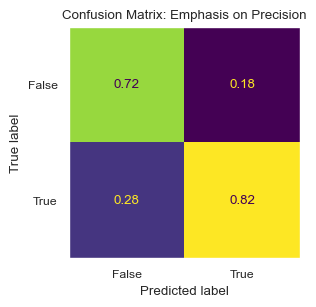

In [41]:
# Create confusion matrix
ConfusionMatrixDisplay.from_estimator(model_gb, X_test, y_test, normalize='pred', colorbar=False)
plt.title('Confusion Matrix: Emphasis on Precision')
ax = plt.gca()
ax.grid(False);

## Business Metrics

Category of the recipe is the variable that has by far the highest predictive power to determine if the recipe will have high traffic. Other variables are less relevant.

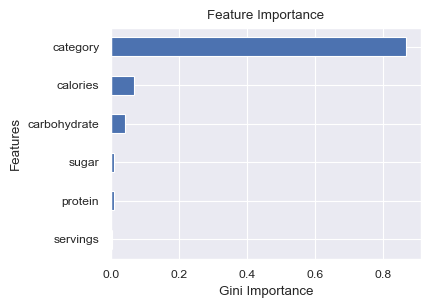

In [42]:
# Get features names from training data
features = model_gb.best_estimator_['preprocessor'].get_feature_names_out()
features = [x[5:] for x in features]

# Extract importances from model
importances = model_gb.best_estimator_['classifier'].feature_importances_

# Create a series with features and importances
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot the features in order of importance
feat_imp.plot(kind='barh', color='b')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.title('Feature Importance');

## Final Summary
- Category is the most important factor that determines if a recipe will have high traffic. 

- Historically, categories like 'chicken', 'breakfast', 'beverages', 'lunch/snacks' have been prevalent among recipes (around 50% of the total). According to our exploratory analysis, there is an urgent need to switch to categories such as 'vegetable', 'potato', 'pork', 'meat', and 'one dish meal', as they seem to increase the chance of a recipe to have a high traffic. Therefore, there must be an emphasis on releasing recipes of these categories.
- Other variables like the nutritional values or number of servings are barely relevant.
- There are other variables present in the recipe displayed which may add predictive power such as 'price per serving' and 'time to make'. This data is unavailable at the moment.
- It is possible to predict if a recipe will have high traffic with a precision of 81.75%. This means that, out of 100 recipes that we predict to have high traffic, at least 81 will have high traffic in reality.


